In [2]:
import numpy as np
import scipy.io
import scipy.integrate
import pylab
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import psd_multitaper
 
%matplotlib inline

mne.set_log_level('WARNING')

## Set Parameters

In [3]:
freq_s = 250    # [Hz] Sampling Frequency
trial_len = 1    # [sec] Length of trial
rest_len = 0.5    # [sec] Length of a rest before the trial
n_channels = 3    # set numpy of channels to use from raw eeg matrix
alpha_range = [8, 14]    # [Hz] range of alpha frequency
alpha_subbands_frq = np.array([np.arange(8,12),np.arange(10,14)]).T.astype(float)    # Sub bands of alpha
print('Alpha frequency range: {}\nAlpha sub bands:\n{}'.format(alpha_range, alpha_subbands_frq))

Alpha frequency range: [8, 14]
Alpha sub bands:
[[  8.  10.]
 [  9.  11.]
 [ 10.  12.]
 [ 11.  13.]]


## Read raw eeg data

In [4]:
# Load Raw EEG
raw_fname = '/Users/leonardrychly/Dropbox/[TUM]/4. WiSe 1617/Masterarbeit/Code/eeg_feature_extraction/exp_0-raw.fif'
raw = mne.io.read_raw_fif(raw_fname, add_eeg_ref=False).load_data()

# Remove EOG channels (channels 4-6)
raw.drop_channels(['eog_4','eog_5', 'eog_6'])

<Raw  |  exp_0-raw.fif, n_channels x n_times : 3 x 604803 (2419.2 sec), ~13.9 MB, data loaded>

## Remove trials with artifacts from 'trials' and 'y' corresponding to the raw eeg data

In [5]:
# Load data containing artifacts
data_path = "/Users/leonardrychly/Dropbox/[TUM]/4. WiSe 1617/Masterarbeit/Code/eeg_feature_extraction/B01T.mat"
mat = scipy.io.loadmat(data_path)['data']

# Get artifacts
exp_arr = mat[0,0]
# explanation:   exp_arr[0][0][data]
exp_dict = {'X': exp_arr[0][0][0].T,
            'trial': exp_arr[0][0][1],
            'y': exp_arr[0][0][2],
            'fs': exp_arr[0][0][3].flatten(),
             'classes': exp_arr[0][0][4].flatten(),
             'artifacts': exp_arr[0][0][5],
             'gender': exp_arr[0][0][6],
             'age': exp_arr[0][0][7].flatten()
             }

# Remove from 'trials' and 'y'
artifact_idx = exp_dict['artifacts'].nonzero()[0]
exp_dict['trial'] = np.delete(exp_dict['trial'], artifact_idx)
exp_dict['y'] = np.delete(exp_dict['y'], artifact_idx)

# Part 1: Sub Band Features

## Crop  part of  EEG raw

In [6]:
# Crop window
start = exp_dict['trial'][0]
stop = start + (trial_len * freq_s)

# Calulate start and stop time from start/stop sample index 
t_start = start / freq_s
t_stop = (start + (trial_len * freq_s)) / freq_s

print('start={}, stop={}, t_start={}, t_stop={}'.format(start, stop, t_start, t_stop))

start=55140, stop=55390, t_start=220.56, t_stop=221.56


In [7]:
# Crop interval (rest + trial)
raw_temp = raw.copy()
trial_t = exp_dict['trial'][0]/freq_s
raw_trial_crop = raw_temp.crop(tmin=trial_t-rest_len, tmax=trial_t+trial_len)

raw_trial_crop

<Raw  |  exp_0-raw.fif, n_channels x n_times : 3 x 376 (1.5 sec), ~21 kB, data loaded>

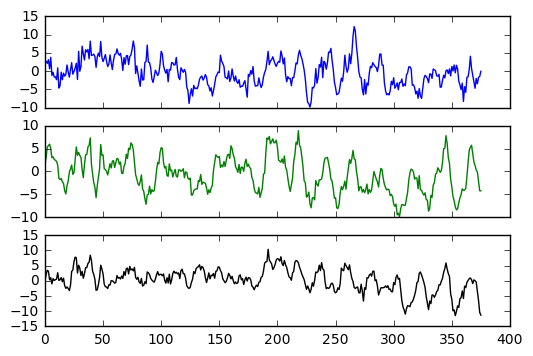

In [8]:
# Plot
raw_segment, times = raw_trial_crop[:, :]

f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(np.arange(len(raw_segment[0])), raw_segment[0], c='blue')
ax1.plot(np.arange(len(raw_segment[1])), raw_segment[1], c='green')
ax2.plot(np.arange(len(raw_segment[2])), raw_segment[2], c='black')

## Filter subbands

In [9]:
# Custom filter length
filter_len = int((trial_len + rest_len) * freq_s)

raw_alpha_sub_list = [[] for _ in range(len(alpha_subbands_frq))]
for sb_idx, subband in enumerate(alpha_subbands_frq):
    raw_temp = raw_trial_crop.copy()
    raw_alpha_sub_list[sb_idx] = raw_temp.filter(l_freq=subband[0], h_freq=subband[1], 
                                                 filter_length=filter_len, l_trans_bandwidth='auto',
                                                 h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                                                 iir_params=None, phase='zero', fir_window='hamming')

In [10]:
# Plot
raw_sub_segment_0, times = raw_alpha_sub_list[0][:, :]
raw_sub_segment_1, times = raw_alpha_sub_list[1][:, :]
raw_sub_segment_2, times = raw_alpha_sub_list[2][:, :]
raw_sub_segment_3, times = raw_alpha_sub_list[3][:, :]

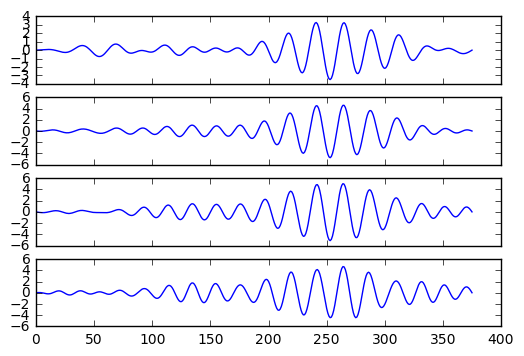

In [11]:
# Sub bands of channel 1
f, (ax0, ax1, ax2, ax3) = plt.subplots(4, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[0])), raw_sub_segment_0[0], c='blue')
ax1.plot(np.arange(len(raw_sub_segment_1[0])), raw_sub_segment_1[0], c='blue')
ax2.plot(np.arange(len(raw_sub_segment_2[0])), raw_sub_segment_2[0], c='blue')
ax3.plot(np.arange(len(raw_sub_segment_3[0])), raw_sub_segment_3[0], c='blue')

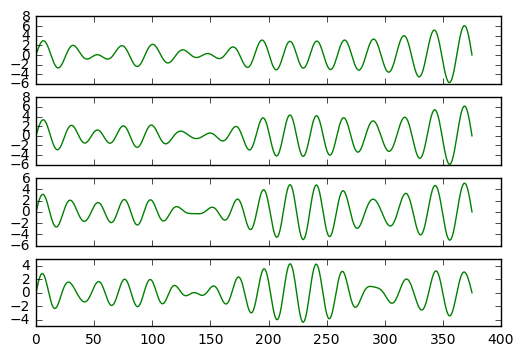

In [12]:
# Sub bands of channel 2
f, (ax0, ax1, ax2, ax3) = plt.subplots(4, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[1])), raw_sub_segment_0[1], c='green')
ax1.plot(np.arange(len(raw_sub_segment_1[1])), raw_sub_segment_1[1], c='green')
ax2.plot(np.arange(len(raw_sub_segment_2[1])), raw_sub_segment_2[1], c='green')
ax3.plot(np.arange(len(raw_sub_segment_3[1])), raw_sub_segment_3[1], c='green')

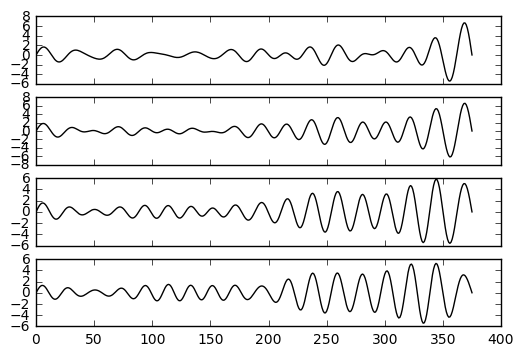

In [13]:
# Sub bands of channel 3
f, (ax0, ax1, ax2, ax3) = plt.subplots(4, sharex=True)
ax0.plot(np.arange(len(raw_sub_segment_0[2])), raw_sub_segment_0[2], c='black')
ax1.plot(np.arange(len(raw_sub_segment_1[2])), raw_sub_segment_1[2], c='black')
ax2.plot(np.arange(len(raw_sub_segment_2[2])), raw_sub_segment_2[2], c='black')
ax3.plot(np.arange(len(raw_sub_segment_3[2])), raw_sub_segment_3[2], c='black')

## Calculate Power Spectral Density

In [14]:
# Freq
fmin, fmax = 1, 20
# Set time range to clacualte PSD
t_croped_start = 0
t_croped_end = t_croped_start + rest_len + trial_len 
print('t_croped_start:' , t_croped_start)
print('t_croped_end:' , t_croped_end)

t_croped_start: 0
t_croped_end: 1.5


### Plot PSD

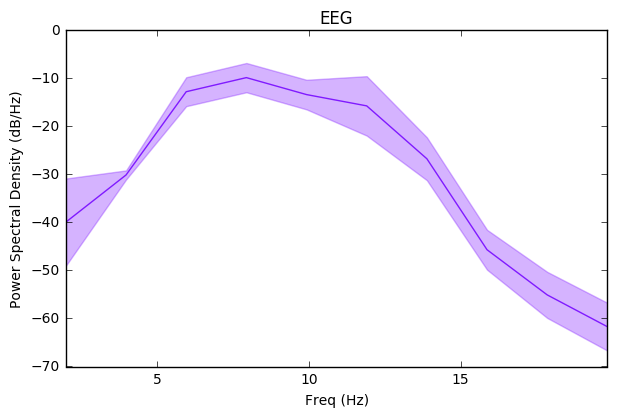

In [15]:
# PSD: Alpha sub band 1 (8-10Hz) REST
p = raw_alpha_sub_list[0].plot_psd(tmin=t_croped_start, tmax=t_croped_end-trial_len, 
                                   fmin=fmin, fmax=fmax, 
                                   color=(0.5, 0.1, 1))

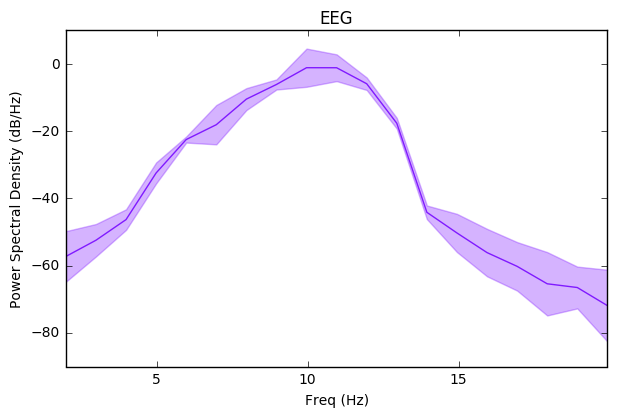

In [16]:
# PSD: Alpha sub band 1 (8-10Hz) TRIAL
p = raw_alpha_sub_list[0].plot_psd(tmin=t_croped_start+rest_len, tmax=t_croped_end, 
                                   fmin=fmin, fmax=fmax, 
                                   color=(0.5, 0.1, 1))

### Calculate PSD (approximate with Multitaper)

#### psds, freqs = psd_multitaper():
* psds : ndarray, shape (..., n_freqs)

The power spectral densities. If input is of type Raw, then psds will be shape (n_channels, n_freqs), if input is type Epochs then psds will be shape (n_epochs, n_channels, n_freqs).
* freqs : ndarray, shape (n_freqs,)

The frequencies.

In [17]:
# PSD for prior to the one alpha sub band REST
f_min, f_max = 0, 20
raw_temp = raw_alpha_sub_list[0].copy()
psds_rest, freqs_rest = psd_multitaper(raw_temp, low_bias=True, 
                                         tmin=t_croped_start, tmax=t_croped_end - trial_len,
                                         fmin=f_min, fmax=f_max, proj=True)

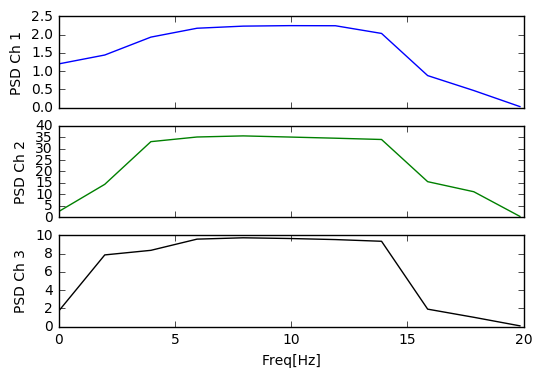

In [18]:
# Plot PSD for each Channel (of sub band 1) REST
f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(freqs_rest, psds_rest[0], c='blue')
ax0.set_ylabel("PSD Ch 1")
ax1.plot(freqs_rest, psds_rest[1], c='green')
ax1.set_ylabel("PSD Ch 2")
ax2.plot(freqs_rest, psds_rest[2], c='black')
ax2.set_xlabel("Freq[Hz]")
ax2.set_ylabel("PSD Ch 3")

In [19]:
# Approximate PSD for one alpha sub band TRIAL
f_min, f_max = 1, 20
raw_temp = raw_alpha_sub_list[0].copy()
psds_trial, freqs_trial = psd_multitaper(raw_temp, low_bias=True, 
                                         tmin=t_croped_start + rest_len, tmax=t_croped_end, 
                                         fmin=f_min, fmax=f_max, proj=True)

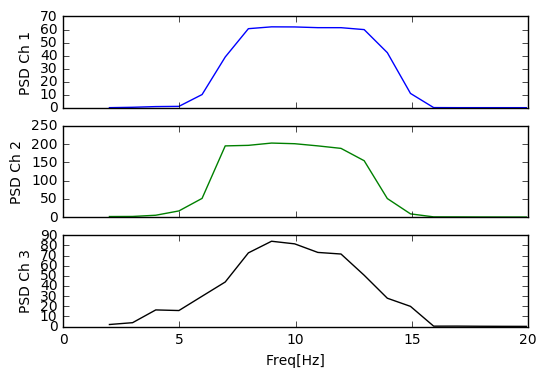

In [20]:
# Plot PSD for each Channel (of sub band 1) TRIAL
f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True)
ax0.plot(freqs_trial, psds_trial[0], c='blue')
ax0.set_ylabel("PSD Ch 1")
ax1.plot(freqs_trial, psds_trial[1], c='green')
ax1.set_ylabel("PSD Ch 2")
ax2.plot(freqs_trial, psds_trial[2], c='black')
ax2.set_xlabel("Freq[Hz]")
ax2.set_ylabel("PSD Ch 3")

## Calulate Power

In [21]:
# Calc power for each channel in alpha sub band 1 TRIAL
powers_trial = []
for psd in psds_trial:
    powers_trial.append(scipy.integrate.simps(psd))
# Alpha sub band 1, channel 1,2,3
powers_trial

[470.9931746542502, 1498.3250341315199, 590.02981105350682]

In [22]:
# Calc power for each channel in alpha sub band 1 REST
powers_rest = []
for psd in psds_rest:
    powers_rest.append(scipy.integrate.simps(psd))
# Alpha sub band 1, channel 1,2,3
powers_rest

[16.443379288666822, 253.20821167530073, 70.190120300962079]

In [23]:
# Difference between trial and Prior
np.array(powers_trial) - np.array(powers_rest)

array([  454.54979537,  1245.11682246,   519.83969075])

#  Part 2: ERS / ERD



- ## ERS - Event Related Synchonization: 
$$ERS[\%] = \big( P_{ERS} - P_{rest} \big) / P_{rest} * 100\% $$


- ## ERD - Event Related Desynchonization:
$$ERD[\%] = \big( P_{ERD} - P_{rest} \big) / P_{rest} * 100\% $$

##  Proprocess RAW EEG

In [24]:
# raw eeg
raw

<Raw  |  exp_0-raw.fif, n_channels x n_times : 3 x 604803 (2419.2 sec), ~13.9 MB, data loaded>

### Crop windows for Rest, ERD, ERS

In [25]:
### Crop window for Alpha and window for Beta
trial_len = 4    # [sec] length of a trial 
rest_len = 1    # [sec] time before trial start
erd_start = 1    # [sec] after trial time start
erd_len = 4    # [sec] length of erd window
ers_start = trial_len    # [sec] after trial time start
ers_len = rest_len    # [sec] length of ers window

trial_start = exp_dict['trial'][0]
trial_stop = trial_start + (trial_len * freq_s)
trial_start_t = trial_start / freq_s
trial_stop_t = (trial_start / freq_s + trial_len) 

# Crop Rest window
tmin_rest = trial_start_t - rest_len
tmax_rest = trial_start_t
raw_temp = raw.copy()
raw_rest = raw_temp.crop(tmin=tmin_rest, tmax=tmax_rest)

# Crop ERD (alpha) window
tmin_erd = trial_start_t + erd_start
tmax_erd = trial_start_t + erd_start + erd_len
raw_temp = raw.copy()
raw_erd = raw_temp.crop(tmin=tmin_erd, tmax=tmax_erd)

# Crop ERS (beta) window
tmin_ers = trial_start_t + ers_start
tmax_ers = trial_start_t + ers_start + ers_len
raw_temp = raw.copy()
raw_ers = raw_temp.crop(tmin=tmin_ers, tmax=tmax_ers)

### Filter windows
- Alpha (8 - 12 Hz)
- Beta (13 - 26 Hz)

In [157]:
# Freq bands
a_band = [8, 12]    # [Hz] alpha band
b_band = [13, 26]    # # [Hz] beta band

In [158]:
# Filter Rest
filter_len_rest = int((tmax_rest - tmin_rest) * freq_s)

# Alpha
raw_temp = raw_rest.copy()
raw_rest_a = raw_temp.filter(l_freq=a_band[0], h_freq=a_band[1], 
                             filter_length=filter_len_rest, l_trans_bandwidth='auto',
                             h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                             iir_params=None, phase='zero', fir_window='hamming')
# Beta
raw_temp = raw_rest.copy()
raw_rest_b = raw_temp.filter(l_freq=b_band[0], h_freq=b_band[1], 
                             filter_length=filter_len_rest, l_trans_bandwidth='auto',
                             h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                             iir_params=None, phase='zero', fir_window='hamming')


Attenuation at stop frequency 6.0Hz is only 17.0dB. Increase filter_length for higher attenuation.


<ipython-input-158-42b0ff513d45>:9: RuntimeWarning: Attenuation at stop frequency 6.0Hz is only 17.0dB. Increase filter_length for higher attenuation.
  iir_params=None, phase='zero', fir_window='hamming')


In [159]:
# Filter ERD
filter_len_erd = int((tmax_erd - tmin_erd) * freq_s)

raw_temp = raw_erd.copy()
raw_erd_a = raw_temp.filter(l_freq=a_band[0], h_freq=a_band[1], 
                            filter_length=filter_len_erd, l_trans_bandwidth='auto',
                            h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                            iir_params=None, phase='zero', fir_window='hamming')


In [160]:
# Filter ERS
filter_len_ers = int((tmax_ers - tmin_ers) * freq_s)

raw_temp = raw_ers.copy()
raw_ers_b = raw_temp.filter(l_freq=b_band[0], h_freq=b_band[1], 
                            filter_length=filter_len_rest, l_trans_bandwidth='auto',
                            h_trans_bandwidth='auto', n_jobs=1, method='fir', 
                            iir_params=None, phase='zero', fir_window='hamming')


### Power

In [161]:
# PSD for Rest (alpha)
f_min_rest_a, f_max_rest_a = 0, 20
raw_temp = raw_rest_a.copy()
psds_rest_a, freqs_rest_a = psd_multitaper(raw_temp, low_bias=True, 
                                           tmin=0, tmax=rest_len, 
                                           fmin=f_min_erd, fmax=f_max_erd, proj=True)

# PSD for Rest (beta)
f_min_rest_a, f_max_rest_a = 10, 30
raw_temp = raw_rest_b.copy()
psds_rest_b, freqs_rest_b = psd_multitaper(raw_temp, low_bias=True, 
                                           tmin=0, tmax=rest_len, 
                                           fmin=f_min_erd, fmax=f_max_erd, proj=True)

# Power for Rest (alpha)
powers_rest_a = np.zeros(len(psds_rest_a))
for i, psd in enumerate(psds_rest_a):
    powers_rest_a[i] = scipy.integrate.simps(psd)
    
print("Rest (alpha) Channel Powers: ", powers_rest_a)

    
# Power for Rest (beta)
powers_rest_b = np.zeros(len(psds_rest_b))
for i, psd in enumerate(psds_rest_b):
    powers_rest_b[i] = scipy.integrate.simps(psd)
    
print("Rest (beta) Channel Powers: ", powers_rest_b)

Rest (alpha) Channel Powers:  [ 1020.88454041  1771.75619381  1155.68470347]
Rest (beta) Channel Powers:  [ 364.64065511  264.17042245  362.83740075]


In [162]:
# PSD for ERD
f_min_erd, f_max_erd = 0, 20

raw_temp = raw_erd_a.copy()
psds_erd, freqs_erd = psd_multitaper(raw_temp, low_bias=True, 
                                     tmin=0, tmax=erd_len, 
                                     fmin=f_min_erd, fmax=f_max_erd, proj=True)
# Power for each channel in ERD 
powers_erd = np.zeros(len(psds_erd))
for i, psd in enumerate(psds_erd):
    powers_erd[i] = scipy.integrate.simps(psd)
    
print("ERD Channel Powers: ", powers_erd)

ERD Channel Powers:  [ 2339.90202462  3801.62676555  4888.65794373]


In [163]:
# PSD for ERS
f_min_ers, f_max_ers = 10, 30

raw_temp = raw_ers_b.copy()
psds_ers, freqs_ers = psd_multitaper(raw_temp, low_bias=True, 
                                     tmin=0, tmax=ers_len, 
                                     fmin=f_min_ers, fmax=f_max_ers, proj=True)
# Power for each channel in ERS
powers_ers = np.zeros(len(psds_ers))
for i, psd in enumerate(psds_ers):
    powers_ers[i] = scipy.integrate.simps(psd)

print("ERS Channel Powers: ", powers_ers)

ERS Channel Powers:  [ 308.16246124  347.55077621  437.62107705]


#### ERD

In [164]:
erd = (powers_erd - powers_rest_a) / powers_rest_a * 100
print("ERD: ", erd)

ERD:  [ 129.2033949   114.56827857  323.00966077]


#### ERS

In [165]:
ers = (powers_ers - powers_rest_b) / powers_rest_b * 100
print("ERS: ", ers)

ERS:  [-15.48872653  31.56309211  20.61079595]
